<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2022-actors/blob/CU-30u4v4d_Analiza-wizualizacja/colabs/Wizualizacje_analiza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Przekopiowane linijki potrzebne do wczytania danych

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/PiotrMaciejKowalski/BigData2022-actors.git
!mv /content/BigData2022-actors/* .
!mv /content/BigData2022-actors/.* .
!rmdir /content/BigData2022-actors/

Cloning into 'BigData2022-actors'...
remote: Enumerating objects: 1208, done.
remote: Counting objects: 100% (427/427), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 1208 (delta 337), reused 250 (delta 235), pack-reused 781
Receiving objects: 100% (1208/1208), 5.89 MiB | 26.43 MiB/s, done.
Resolving deltas: 100% (685/685), done.
mv: cannot move '/content/BigData2022-actors/.' to './.': Device or resource busy
mv: cannot move '/content/BigData2022-actors/..' to './..': Device or resource busy


In [3]:
!git checkout Refactoring

error: pathspec 'Refactoring' did not match any file(s) known to git.


In [4]:
!chmod +x setup_sparka.sh
!./setup_sparka.sh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 200 kB 53.2 MB/s 
     |████████████████████████████████| 199 kB 12.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4924afba0f4b41bc9536a094d75ce017bf95ce07b2b16a71bcb0eb9a9f460266
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
--2022-12-19 23:51:48--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274099817 (261M) [application/x-gzip]
Saving to: ‘spark-3.3.1-bin-hadoop2.tgz’

spark-3.3.1-bin-had 100%[===============

In [5]:
import pandas as pd
from lib.pyspark_init import create_spark_context, add_kaggle_data

In [6]:
spark = create_spark_context()
spark

In [8]:
!chmod +x download_data.sh
!./download_data.sh

--2022-12-19 23:56:26--  https://datasets.imdbws.com/name.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.91, 13.249.98.35, 13.249.98.73, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238074758 (227M) [binary/octet-stream]
Saving to: ‘name.basics.tsv.gz’

name.basics.tsv.gz  100%[===================>] 227.04M   131MB/s    in 1.7s    

2022-12-19 23:56:28 (131 MB/s) - ‘name.basics.tsv.gz’ saved [238074758/238074758]

--2022-12-19 23:56:28--  https://datasets.imdbws.com/title.akas.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.91, 13.249.98.35, 13.249.98.73, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291123172 (278M) [binary/octet-stream]
Saving to: ‘title.akas.tsv.gz’

title.akas.tsv.gz   100%[===================>] 277.64M   127MB

In [9]:
df_title_basic = (
        spark.read.option("header", "true")
        .option("delimiter", "\t")
        .csv("title.basic.csv")
    )

In [90]:
df_title_basic.createOrReplaceTempView('df_title_basic')

#Wizualizacje - wykresy i posortowane tabele

In [91]:
Appearances = spark.sql("""SELECT (LENGTH(knownForTitles) - LENGTH(REPLACE(knownForTitles,",","")) + 1) AS CounterknownForTitles, count(*) as ilu_aktorow from df_title_basic group by CounterknownForTitles""").toPandas()
Appearances

AnalysisException: ignored

Kolumna "startYear":
wartości są z przedziału [1874,2029] oraz nulle, których jest 1 266 394. W oczy rzuca się wykładniczy charakter wzrostu liczby produkcji wraz z upływem czasu, żeby w 2021 osiągnąć peak liczebności produkcji rzędu 440 548.
Zniknęły takie anomalie jak wartości startYear = 0004.

In [93]:
#spark.sql("""SELECT startYear, count(*) as liczba_wystapien from df_title_basic group by startYear""").show(100)
temp1 = spark.sql("""SELECT startYear, count(*) as liczba_wystapien from df_title_basic where startYear<2031 group by startYear order by startYear asc""").toPandas()


In [94]:
temp1

,startYear,liczba_wystapien
0,1874,1
1,1877,4
2,1878,2
3,1881,2
4,1882,2
...,...,...
145,2025,144
146,2026,43
147,2027,15
148,2028,7


In [68]:
temp1 = spark.sql("""SELECT startYear, count(*) as liczba_wystapien from df_title_basic group by startYear order by startYear asc""").show(151)

+---------+----------------+
|startYear|liczba_wystapien|
+---------+----------------+
|     1874|               1|
|     1877|               4|
|     1878|               2|
|     1881|               2|
|     1882|               2|
|     1883|               1|
|     1885|               1|
|     1887|              45|
|     1888|               5|
|     1889|               2|
|     1890|               6|
|     1891|              10|
|     1892|               9|
|     1893|               3|
|     1894|              99|
|     1895|             115|
|     1896|             852|
|     1897|            1356|
|     1898|            1796|
|     1899|            1820|
|     1900|            1862|
|     1901|            1769|
|     1902|            1811|
|     1903|            2676|
|     1904|            1837|
|     1905|            1705|
|     1906|            1858|
|     1907|            2490|
|     1908|            4300|
|     1909|            5438|
|     1910|            6419|
|     1911|   

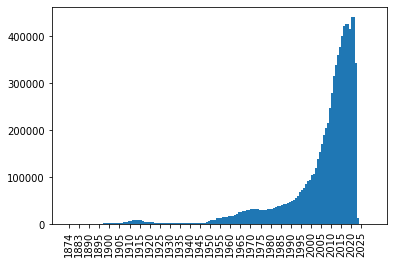

In [95]:
plt.bar(temp1.startYear, temp1.liczba_wystapien, width = 2)
plt.xticks(temp1.startYear[::5], rotation='vertical')
plt.show()

Kolumna "endYear":
wartości są z przedziału [1906,2030] oraz nulle, których jest 9 357 477, czyli mniej więcej 8 razy więcej niż nulli w startYear.
Liczba nulli sugeruje z góry liczbę nadal tworzonych produkcji jakiegolwiek rodzaju. 

In [83]:
temp2 = spark.sql("""SELECT endYear, count(*) as liczba_wystapien from df_title_basic where endYear<2031 group by endYear order by endYear asc""").toPandas()


In [88]:
spark.sql("""SELECT endYear, count(*) as liczba_wystapien from df_title_basic group by endYear order by endYear asc""").toPandas()
#nulli jest 9357447

,endYear,liczba_wystapien
0,1906,1
1,1925,1
2,1932,11
3,1933,2
4,1934,1
...,...,...
92,2026,3
93,2027,2
94,2028,1
95,2030,1


In [84]:
temp2

,endYear,liczba_wystapien
0,1906,1
1,1925,1
2,1932,11
3,1933,2
4,1934,1
...,...,...
91,2025,7
92,2026,3
93,2027,2
94,2028,1


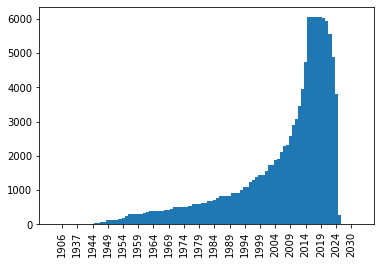

In [97]:
plt.bar(temp2.endYear, temp2.liczba_wystapien, width = 5)
plt.xticks(temp2.endYear[::5], rotation='vertical')
plt.show()
